# Finding the planetary mass-radius 2D distribution

Here we model the joint probability function of the exoplanet mass and exoplanet radius using parametric (Gaussian mixture model) and non-parametric (KDE) methods

In [84]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

Initial plot of data to get an idea of the distribution

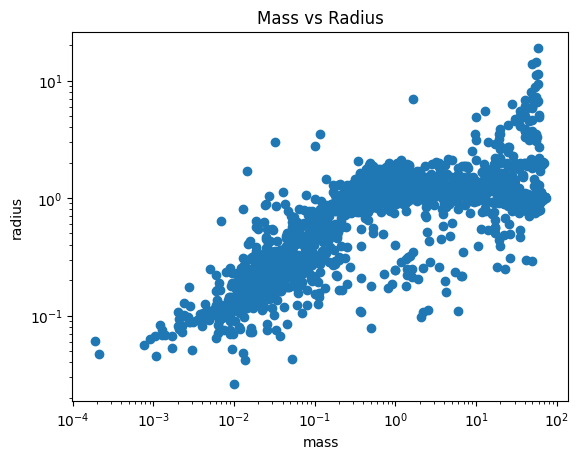

In [ ]:
df = pd.read_csv(r"exoplanet_catalogue.csv")-

df = df.dropna(subset = ['mass', 'radius']).copy()
plt.scatter(x = df['mass'], y = df['radius'])
plt.title('Mass vs Radius')
plt.ylabel('radius')
plt.xlabel('mass')
plt.xscale('log')
plt.yscale('log')

# Fitting the models

In [86]:
# Load and preprocess data
df = pd.read_csv("exoplanet_catalogue.csv")
df = df.dropna(subset=['mass', 'radius']).copy()

# Create log-transformed data for better visualization and modeling
df['log_mass'] = np.log10(df['mass'])
df['log_radius'] = np.log10(df['radius'])

# Extract the data as numpy arrays for modeling
log_mass = df['log_mass'].values
log_radius = df['log_radius'].values
data = np.vstack([log_mass, log_radius]).T
xmin, xmax = log_mass.min(), log_mass.max()
ymin, ymax = log_radius.min(), log_radius.max()

# 1. KDE Approach
# -----------------------
# Create a 2D KDE using scipy.stats
x = df['log_mass'].values
y = df['log_radius'].values

# Create grid of points
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])

# Compute the KDE
kernel = stats.gaussian_kde(values)

# 2. Simple Multivariate Normal PDF
# ---------------------------------
# Extract the data as numpy arrays for modeling
mean = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)
mvn = multivariate_normal(mean=mean, cov=cov)

# 3. Gaussian Mixture Model with explicit weights
# ----------------------------------------------
def fit_gmm(n_components):
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    return gmm


Finding the optimal number of components for GMM

GMM with 2 components: AIC = 5725.0970187676385, BIC = 5786.908586346133
GMM with 3 components: AIC = 4842.2406674320655, BIC = 4937.767635507921
GMM with 4 components: AIC = 4430.401325143254, BIC = 4559.643693716471
GMM with 5 components: AIC = 4133.885132728919, BIC = 4296.842901799497
GMM with 6 components: AIC = 4053.6171385556486, BIC = 4250.290308123587
GMM with 7 components: AIC = 3879.799482763242, BIC = 4110.188052828541
GMM with 8 components: AIC = 4002.7141387730426, BIC = 4266.8181093357025
GMM with 9 components: AIC = 3739.365538200398, BIC = 4037.184909260419
GMM with 10 components: AIC = 3737.5518934490947, BIC = 4069.0866650064763
MVN: Log-likelihood = -3463.31, Parameters = 5
GMM-2: Log-likelihood = -2851.55, Parameters = 11
GMM-3: Log-likelihood = -2404.12, Parameters = 17
GMM-4: Log-likelihood = -2192.20, Parameters = 23
GMM-5: Log-likelihood = -2037.94, Parameters = 29
GMM-6: Log-likelihood = -1991.81, Parameters = 35
GMM-7: Log-likelihood = -1898.90, Parameters = 

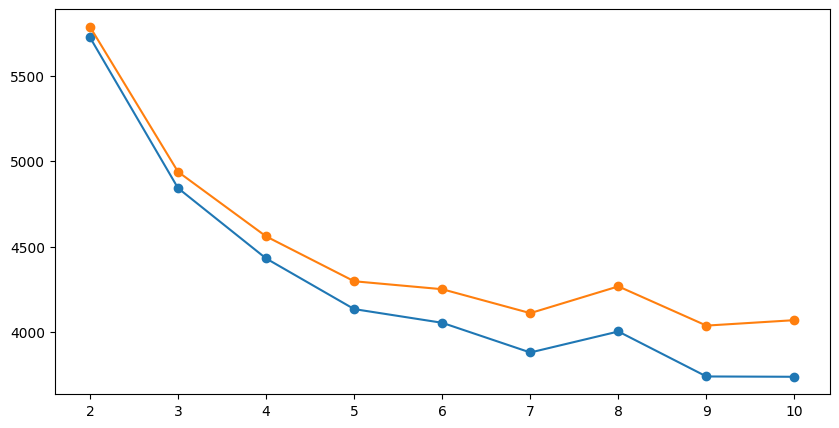

In [87]:
# Create GMMs with different component counts
gmm_models = {n: fit_gmm(n) for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]}

AIC, BIC = [], []
for n_components, gmm in gmm_models.items():
    print(f"GMM with {n_components} components: AIC = {gmm.aic(data)}, BIC = {gmm.bic(data)}")
    AIC.append(gmm.aic(data))
    BIC.append(gmm.bic(data))
# Plot AIC and BIC
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), AIC, marker='o', label='AIC')
plt.plot(range(2, 11), BIC, marker='o', label='BIC')

def compare_models_likelihood_ratio(data, models, alpha=0.01):
    """
    Compare models of increasing complexity using likelihood ratio tests
    
    Parameters:
    -----------
    data : numpy.ndarray
        Original data with shape (n_samples, n_features)
    models : list of tuples
        List of (model_name, log_likelihood_func, n_params) tuples
        - model_name: name of the model
        - log_likelihood_func: function to calculate log-likelihood of data
        - n_params: number of parameters in the model
    alpha : float, optional
        Significance level
        
    Returns:
    --------
    dict
        Dictionary with test results comparing models
    """
    import numpy as np
    from scipy import stats
    
    results = {}
    n_samples = data.shape[0]
    
    # Sort models by complexity (number of parameters)
    sorted_models = sorted(models, key=lambda x: x[2])
    
    # Calculate log-likelihood for each model
    log_likelihoods = {}
    for model_name, log_lik_func, n_params in sorted_models:
        log_likelihoods[model_name] = log_lik_func(data)
        print(f"{model_name}: Log-likelihood = {log_likelihoods[model_name]:.2f}, Parameters = {n_params}")
    
    # Compare each model to the next more complex one
    for i in range(len(sorted_models) - 1):
        simple_model = sorted_models[i]
        complex_model = sorted_models[i+1]
        
        simple_name, _, simple_params = simple_model
        complex_name, _, complex_params = complex_model
        
        # Calculate likelihood ratio statistic (-2 * log(likelihood_ratio))
        lr_statistic = -2 * (log_likelihoods[simple_name] - log_likelihoods[complex_name])
        
        # Degrees of freedom = difference in number of parameters
        df = complex_params - simple_params
        
        # Calculate p-value (chi-squared distribution)
        p_value = 1 - stats.chi2.cdf(lr_statistic, df)
        
        results[f"{simple_name} vs {complex_name}"] = {
            'LR_statistic': lr_statistic,
            'df': df,
            'p_value': p_value,
            'reject_H0': p_value < alpha,
            'preferred_model': complex_name if p_value < alpha else simple_name
        }
        
        print(f"\nComparing {simple_name} (H0) vs {complex_name} (H1):")
        print(f"  LR statistic: {lr_statistic:.4f}")
        print(f"  Degrees of freedom: {df}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Decision: {'Reject H0' if p_value < alpha else 'Fail to reject H0'} at α={alpha}")
        print(f"  Preferred model: {complex_name if p_value < alpha else simple_name}")
        if not p_value < alpha:
            print("  H0 is preferred (no significant difference)")
            break
    
    # Find the overall best model (most complex that is still preferred)
    all_comparisons = list(results.values())
    preferred_models = [result['preferred_model'] for result in all_comparisons]
    
    # The best model is the most complex one that's still preferred
    model_complexity = {model[0]: model[2] for model in sorted_models}
    best_model = max(preferred_models, key=lambda m: model_complexity.get(m, 0))
    
    print(f"\nBest model based on hypothesis testing: {best_model}")
    
    return results

def evaluate_models_hierarchical():
    """
    Evaluate models using a hierarchical approach where simpler models are null hypotheses
    """
    # Create log-transformed data for modeling
    log_data = np.vstack([log_mass, log_radius]).T
    
    # Define log-likelihood functions for each model
    def mvn_log_likelihood(data):
        # For multivariate normal, sum log of PDF evaluations
        return np.sum(mvn.logpdf(data))
    
    def gmm_log_likelihood(data, n_components):
        # For GMM, use score_samples which returns log-likelihood
        return np.sum(gmm_models[n_components].score_samples(data))
    
    # Count parameters for each model
    # MVN: mean vector (2) + covariance matrix elements (3) = 5 params
    mvn_params = 5  # 2 means + 3 unique elements in 2x2 covariance matrix
    
    # GMM: (mean vector + covariance matrix + weight) * components - 1
    # Each component has: 2 means + 3 covariances + 1 weight, but weights sum to 1
    gmm2_params = (2 + 3 + 1) * 2 - 1    
    gmm3_params = (2 + 3 + 1) * 3 - 1    
    gmm4_params = (2 + 3 + 1) * 4 - 1    
    gmm5_params = (2 + 3 + 1) * 5 - 1    
    gmm6_params = (2 + 3 + 1) * 6 - 1    
    gmm7_params = (2 + 3 + 1) * 7 - 1    
    gmm8_params = (2 + 3 + 1) * 8 - 1    
    gmm9_params = (2 + 3 + 1) * 9 - 1    
    gmm10_params = (2 + 3 + 1) * 10 - 1  
    
    # Define models in order of increasing complexity
    models = [
        ("MVN", lambda data: mvn_log_likelihood(data), mvn_params),
        ("GMM-2", lambda data: gmm_log_likelihood(data, 2),  gmm2_params),
        ("GMM-3", lambda data: gmm_log_likelihood(data, 3),  gmm3_params),
        ("GMM-4", lambda data: gmm_log_likelihood(data, 4),  gmm4_params),
        ("GMM-5", lambda data: gmm_log_likelihood(data, 5),  gmm5_params),
        ("GMM-6", lambda data: gmm_log_likelihood(data, 6),  gmm6_params),
        ("GMM-7", lambda data: gmm_log_likelihood(data, 7),  gmm7_params),
        ("GMM-8", lambda data: gmm_log_likelihood(data, 8),  gmm8_params),
        ("GMM-9", lambda data: gmm_log_likelihood(data, 9),  gmm9_params),
        ("GMM-10", lambda data: gmm_log_likelihood(data, 10), gmm10_params),
    ]
    
    # Run model comparison
    results = compare_models_likelihood_ratio(log_data, models, alpha=0.01)
    
    return results

evaluate_models_hierarchical()
print('done')

The optimal number of components for GMM was found to be 7. For visualization we will look at 2,4,7 components

In [88]:
components = [2, 4, 7]
# fitting for 2, 4, and 7 components
gmm_models = {n: fit_gmm(n) for n in components}

Here we are defining the probability density functions for the fitted models

In [89]:
# Function to evaluate KDE at specific points
def kde_pdf(mass, radius):
    log_mass = np.log10(mass)
    log_radius = np.log10(radius)
    point = np.vstack([log_mass, log_radius])
    return kernel(point)

# Function to sample from the KDE
def sample_from_kde(n_samples):
    # For KDE, we can directly use the resample method
    samples = kernel.resample(n_samples)
    # Convert back from log space to original scale
    return 10**samples[0, :], 10**samples[1, :]

def multivariate_normal_pdf(mass, radius):
    log_mass = np.log10(mass)
    log_radius = np.log10(radius)
    point = np.array([log_mass, log_radius])
    return mvn.pdf(point)

# Function to sample from single multivariate normal
def sample_from_mvn(n_samples):
    samples = mvn.rvs(size=n_samples)
    # Convert back from log space
    return 10**samples[:, 0], 10**samples[:, 1]

# Function using scikit-learn's built-in method
def gmm_pdf(mass, radius, n_components):
    log_mass = np.log10(mass)
    log_radius = np.log10(radius)
    point = np.array([[log_mass, log_radius]])
    gmm = gmm_models[n_components]
    return np.exp(gmm.score_samples(point))[0]

# Function to sample from the fitted GMM
def sample_from_gmm(n_samples, n_components):
    gmm = gmm_models[n_components]
    samples, _ = gmm.sample(n_samples)
    # Convert back from log space
    return 10**samples[:, 0], 10**samples[:, 1]

Here we double check the that the joint pdf is normalized

In [90]:
from scipy import integrate

x = df['log_mass'].values
y = df['log_radius'].values
data = np.vstack([log_mass, log_radius]).T

# Function to check normalization of GMM PDFs
def check_normalization(gmm_models):
    results = {}
    
    for n_components, gmm in gmm_models.items():
        # For 2D data, we need to integrate over a 2D grid
        # Determine bounds that cover most of the probability mass
        data_min = np.min(data, axis=0) - 5
        data_max = np.max(data, axis=0) + 5
        
        # Define the PDF function for this GMM
        def gmm_pdf_check(x, y):
            return np.exp(gmm.score_samples(np.array([[x, y]])))
        
        # Use scipy's dblquad for double integral
        integral, error = integrate.dblquad(
            gmm_pdf_check, 
            data_min[0], data_max[0],  # x bounds
            lambda x: data_min[1], lambda x: data_max[1]  # y bounds
        )
        
        results[n_components] = {
            'integral': integral,
            'error': error,
            'normalized': np.isclose(integral, 1.0, rtol=1e-2)
        }
    
    return results

# Execute method and print results
print("Checking normalization using numerical integration:")
results_numerical = check_normalization(gmm_models)
for n, result in results_numerical.items():
    print(f"GMM with {n} components:")
    print(f"  Integral: {result['integral']:.6f}")
    print(f"  Error: {result['error']:.6f}")
    print(f"  Normalized: {result['normalized']}")
    print()



Checking normalization using numerical integration:
GMM with 2 components:
  Integral: 1.000000
  Error: 0.000000
  Normalized: True

GMM with 4 components:
  Integral: 1.000000
  Error: 0.000000
  Normalized: True

GMM with 7 components:
  Integral: 1.000000
  Error: 0.000000
  Normalized: True



In [ ]:
# checking the KDE pdf

x = df['log_mass'].values
y = df['log_radius'].values

data = np.vstack([log_mass, log_radius]).T

# Function to check normalization of KDE PDFs
def check_normalization_kde():
    results = {}

    # For 2D data, we need to integrate over a 2D grid
    # Determine bounds that cover most of the probability mass
    data_min = np.min(data, axis=0) - 5
    data_max = np.max(data, axis=0) + 5
    
    # Function to evaluate KDE at specific points
    def kde_pdf_check(x, y):
        point = np.vstack([x, y])
        return kernel(point)

    # Use scipy's dblquad for double integral
    integral, error = integrate.dblquad(
        kde_pdf_check, 
        data_min[0], data_max[0],  # x bounds
        lambda x: data_min[1], lambda x: data_max[1]  # y bounds
    )
    
    results[n_components] = {
        'integral': integral,
        'error': error,
        'normalized': np.isclose(integral, 1.0, rtol=1e-2)
    }
    
    return results

# Execute method and print results
print("Checking normalization using numerical integration:")
results_numerical = check_normalization_kde()
for n, result in results_numerical.items():
    print(f"  Integral: {result['integral']:.6f}")
    print(f"  Error: {result['error']:.6f}")
    print(f"  Normalized: {result['normalized']}")
    print()

Checking normalization using numerical integration:
  Integral: 1.000000
  Error: 0.000000
  Normalized: True



# Visualiztion

GMM with 2 components, weights: [0.36214883 0.63785117], sum: 1.0
GMM with 4 components, weights: [0.30246523 0.38306264 0.18821386 0.12625827], sum: 1.0000000000000002
GMM with 7 components, weights: [0.06328547 0.19635742 0.07235291 0.1706005  0.20051292 0.17011819
 0.1267726 ], sum: 1.0000000000000002


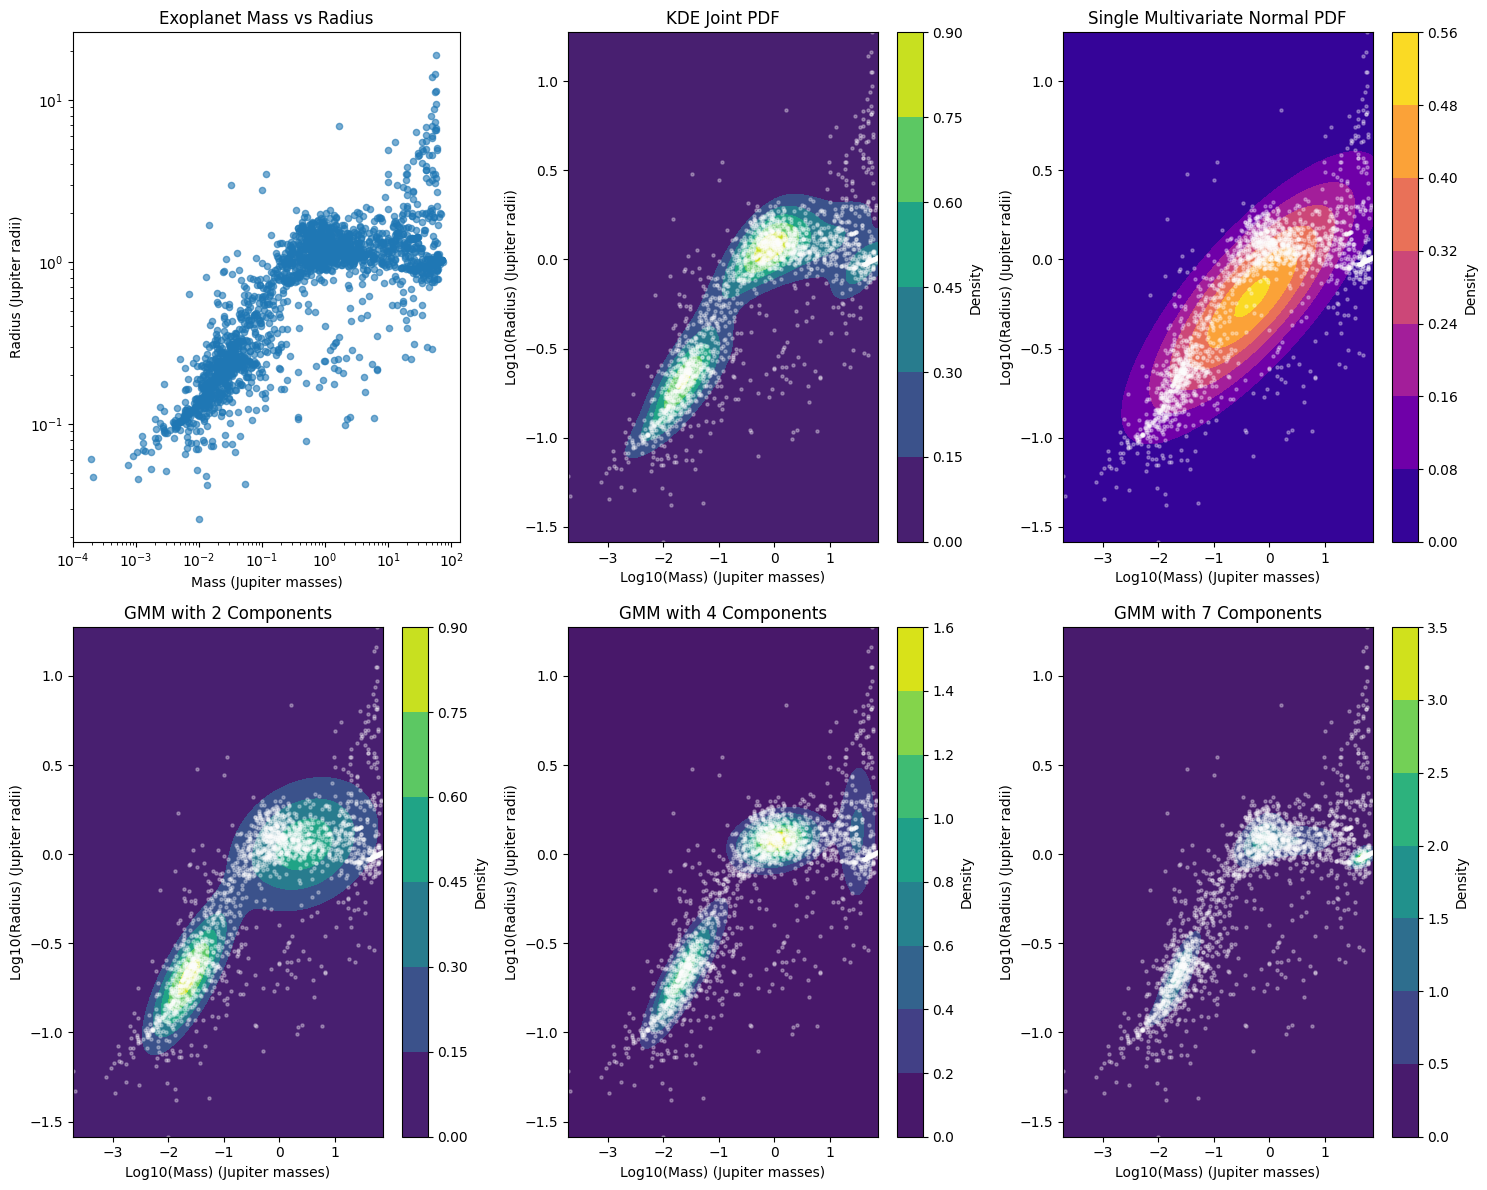

In [92]:
# Visualize the models and data
plt.figure(figsize=(15, 12))

# Original scatter plot
plt.subplot(2, 3, 1)
plt.scatter(df['mass'], df['radius'], alpha=0.6, s=20)
plt.xlabel('Mass (Jupiter masses)')
plt.ylabel('Radius (Jupiter radii)')
plt.title('Exoplanet Mass vs Radius')
plt.xscale('log')
plt.yscale('log')

# KDE visualization
plt.subplot(2, 3, 2)
Z = np.reshape(kernel(positions).T, X.shape)
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(log_mass, log_radius, s=5, alpha=0.3, color='white')
plt.xlabel('Log10(Mass) (Jupiter masses)')
plt.ylabel('Log10(Radius) (Jupiter radii)')
plt.title('KDE Joint PDF')

# Single multivariate normal
plt.subplot(2, 3, 3)
pos = np.dstack((X, Y))
Z_mvn = mvn.pdf(pos)
plt.contourf(X, Y, Z_mvn, cmap='plasma')
plt.colorbar(label='Density')
plt.scatter(log_mass, log_radius, s=5, alpha=0.3, color='white')
plt.xlabel('Log10(Mass) (Jupiter masses)')
plt.ylabel('Log10(Radius) (Jupiter radii)')
plt.title('Single Multivariate Normal PDF')

# GMM with different components
for i, n_components in enumerate(components):
    plt.subplot(2, 3, i+4)
    
    gmm = gmm_models[n_components]
    # Print the weights to verify normalization
    print(f"GMM with {n_components} components, weights: {gmm.weights_}, sum: {np.sum(gmm.weights_)}")
    
    # Create a mesh grid for visualization
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    # Reshape the grid for prediction
    pos_flat = pos.reshape(-1, 2)
    Z_gmm = np.exp(gmm.score_samples(pos_flat))
    Z_gmm = Z_gmm.reshape(X.shape)
    
    # Plot
    plt.contourf(X, Y, Z_gmm, cmap='viridis')
    plt.colorbar(label='Density')
    plt.scatter(log_mass, log_radius, s=5, alpha=0.3, color='white')
    plt.xlabel('Log10(Mass) (Jupiter masses)')
    plt.ylabel('Log10(Radius) (Jupiter radii)')
    plt.title(f'GMM with {n_components} Components')

plt.tight_layout()
plt.show()



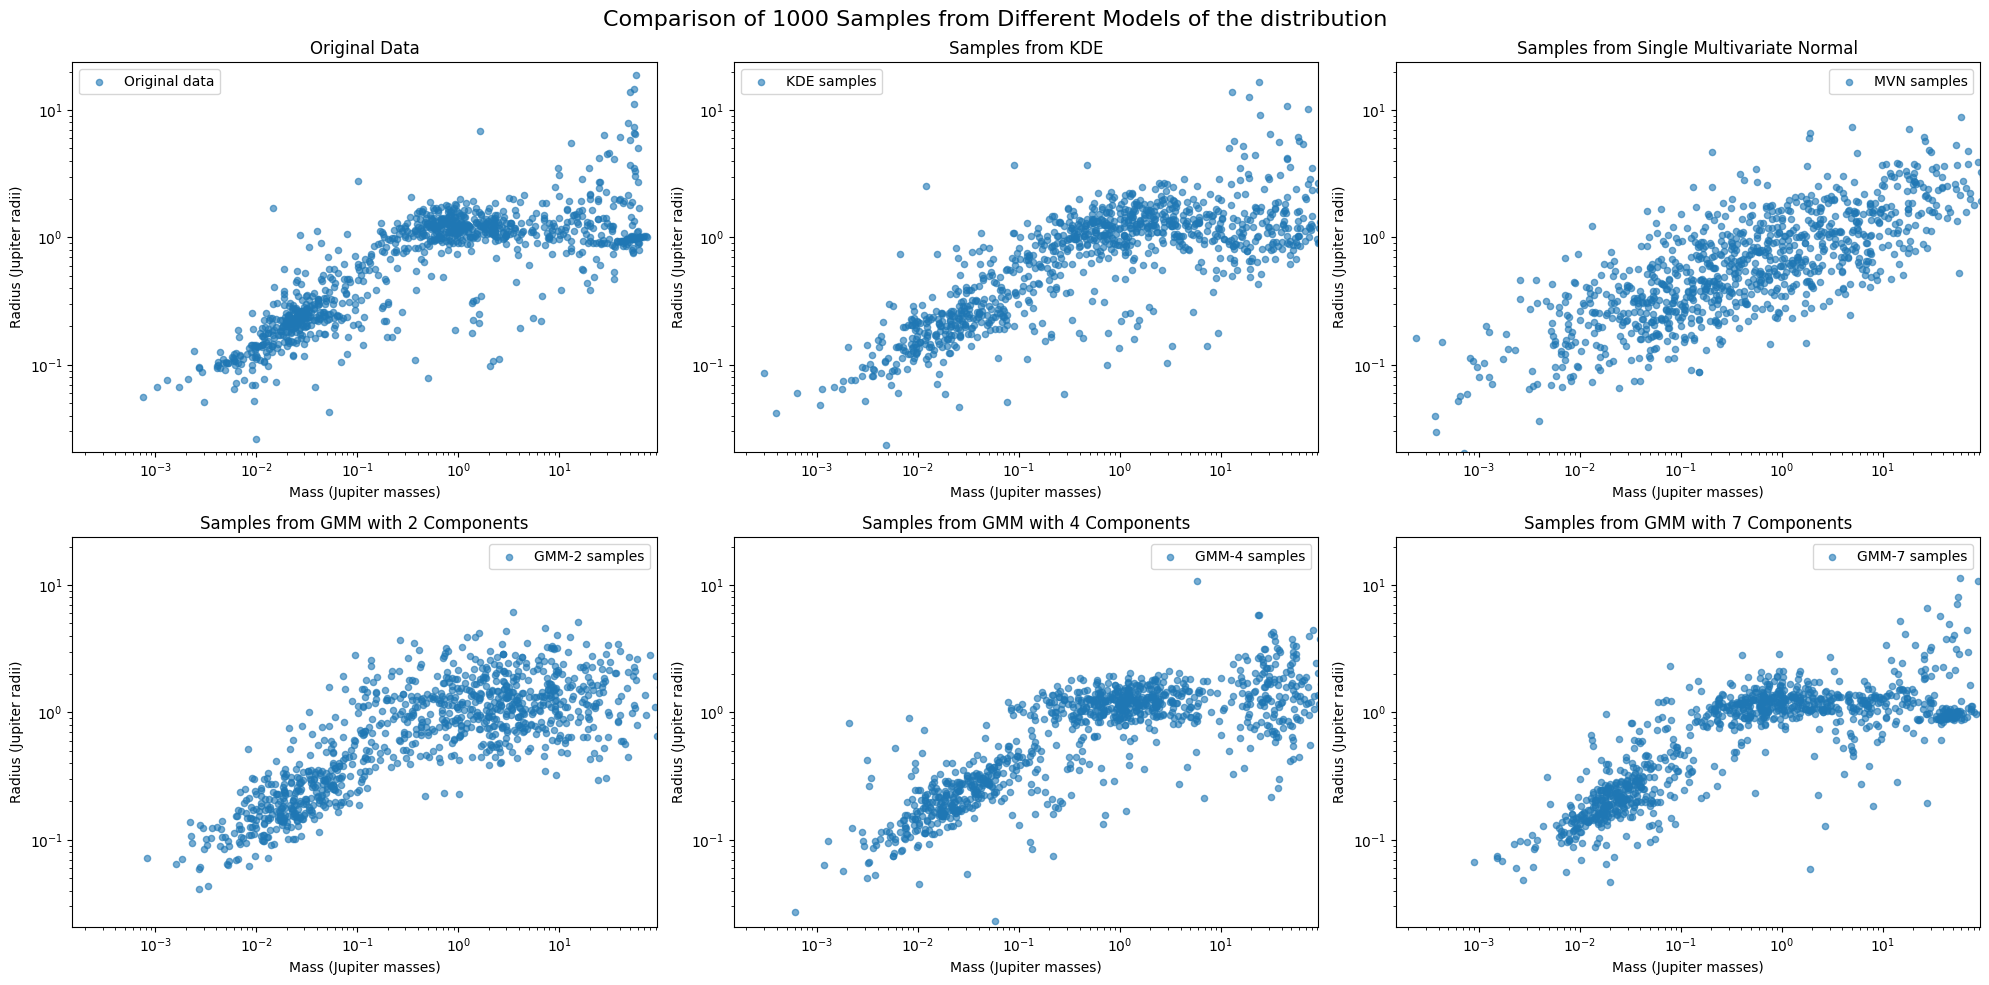

In [93]:
# Generate and plot samples from all models
n_samples = 1000

plt.figure(figsize=(20, 10))

# Compute global x/y limits from the original data
pad = 0.1
factor = 10**pad  # ≈1.12
x_limits = (df['mass'].min() / factor,
            df['mass'].max() * factor)
y_limits = (df['radius'].min() / factor,
            df['radius'].max() * factor)

# Add the suptitle 
plt.suptitle(f'Comparison of {n_samples} Samples from Different Models of the distribution', fontsize=16)

# Original data
plt.subplot(2, 3, 1)

plt.scatter(*df.sample(n=n_samples, random_state=42)[['mass','radius']].values.T,
            alpha=0.6, s=20, label='Original data')

plt.xlabel('Mass (Jupiter masses)')
plt.ylabel('Radius (Jupiter radii)')
plt.title('Original Data')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# KDE samples
plt.subplot(2, 3, 2)
kde_mass_samples, kde_radius_samples = sample_from_kde(n_samples)
plt.scatter(kde_mass_samples, kde_radius_samples, alpha=0.6, s=20, label='KDE samples')
# plt.scatter(df['mass'], df['radius'], alpha=0.1, s=10, color='gray', label='Original data')
plt.xlabel('Mass (Jupiter masses)')
plt.ylabel('Radius (Jupiter radii)')
plt.title('Samples from KDE')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# MVN samples
plt.subplot(2, 3, 3)
mvn_mass_samples, mvn_radius_samples = sample_from_mvn(n_samples)
plt.scatter(mvn_mass_samples, mvn_radius_samples, alpha=0.6, s=20, label='MVN samples')
# plt.scatter(df['mass'], df['radius'], alpha=0.1, s=10, color='gray', label='Original data')
plt.xlabel('Mass (Jupiter masses)')
plt.ylabel('Radius (Jupiter radii)')
plt.title('Samples from Single Multivariate Normal')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# GMM samples for different component counts
for i, n_components in enumerate(components):
    plt.subplot(2, 3, i+4)
    mass_samples, radius_samples = sample_from_gmm(n_samples, n_components)
    plt.scatter(mass_samples, radius_samples, alpha=0.6, s=20, label=f'GMM-{n_components} samples')
    # plt.scatter(df['mass'], df['radius'], alpha=0.1, s=10, color='gray', label='Original data')
    plt.xlabel('Mass (Jupiter masses)')
    plt.ylabel('Radius (Jupiter radii)')
    plt.title(f'Samples from GMM with {n_components} Components')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

# Enforce the same limits on every subplot
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(x_limits)   # set same x‑limits for all :contentReference[oaicite:0]{index=0}
    ax.set_ylim(y_limits)   # set same y‑limits for all :contentReference[oaicite:1]{index=1}

plt.tight_layout()
plt.show()

Finally our models to be saved GMM and KDE (not yet done)

In [94]:
gmm_models
kernel